### Standard Lib Imports

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
from src import config
from src.helper import *

### Load Data
For this notebook, we will load in all the datasets and combine and compare them.

In [3]:
fnames = [f for f in os.listdir(config.DATA_PATH) if f.endswith('.csv')]
fnames.sort()

In [4]:
fnames

['Availability.csv',
 'Prices.csv',
 'Product Details.csv',
 'Purchase.csv',
 'Sales.csv',
 'Visits on PDP.csv']

In [5]:
data = []

for fname in fnames:
    data.append(read_data(fname))

In [6]:
# Separate into individual dataframes 

availability = data[0]
prices = data[1]
product_details = data[2]
purchase = data[3]
sales = data[4]
visits_on_pdp = data[5]

del data

In [7]:
# Correct column name in Product Details dataframe
product_details = product_details.rename({'product_id*31': 'product_id'}, axis=1)

In [8]:
sales['date'] = pd.to_datetime(sales['date'])
purchase['date'] = pd.to_datetime(purchase['date'])
visits_on_pdp['date'] = pd.to_datetime(visits_on_pdp['date'])
availability['date'] = pd.to_datetime(availability['date'])

### Understanding Page Visits vs. Sales

In [16]:
visits_sales = visits_on_pdp.merge(sales, on=['product_id', 'date'], how='left').fillna(0)

In [20]:
visits_sales.loc[:, 'visits'] = visits_sales.loc[:, 'visits'].fillna(0)
visits_sales = visits_sales.rename({'quantity': 'sales'}, axis=1)

In [21]:
visits_sales.head()

,date,product_id,visits,sales
0,2020-01-02,332504078,12,0.0
1,2020-01-04,331574605,26,0.0
2,2020-01-04,341256897,219,0.0
3,2020-01-05,344211135,48,0.0
4,2020-01-04,327381483,69,0.0


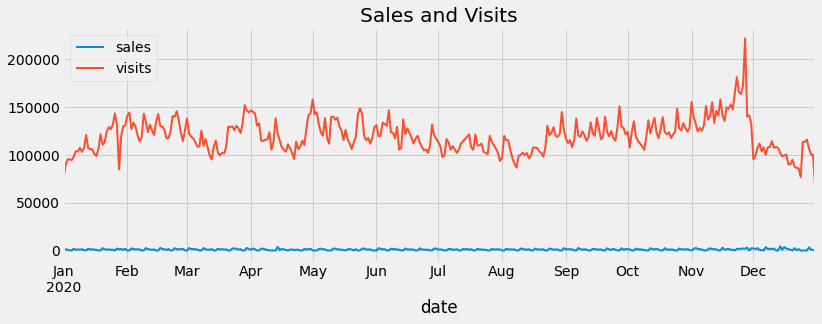

In [22]:
visits_sales.groupby('date')[['sales', 'visits']].sum().plot(linewidth=config.lw, figsize=(config.FIGSIZE))
plt.title('Sales and Visits');

In [23]:
scaler = StandardScaler()
visits_sales['sales_scaled'] = scaler.fit_transform(visits_sales.loc[:, ['sales']])
visits_sales['visits_scaled'] = scaler.fit_transform(visits_sales.loc[:, ['visits']])

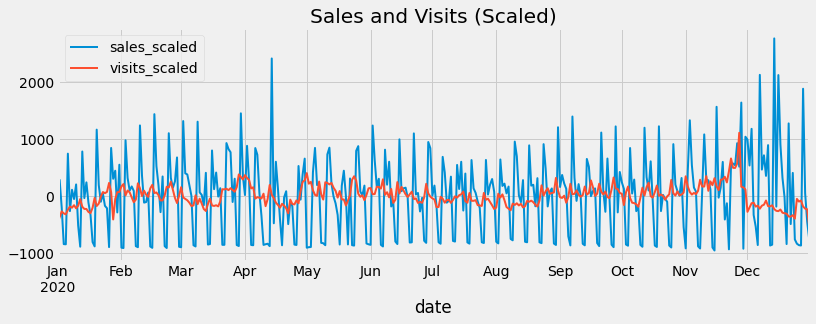

In [24]:
visits_sales.groupby('date')[['sales_scaled', 'visits_scaled']].sum()\
    .plot(linewidth=config.lw, figsize=(config.FIGSIZE))
plt.title('Sales and Visits (Scaled)');

- We can see how the sales is much more variable than the visits. 

In [25]:
visits_sales_corr = np.corrcoef(visits_sales['sales'], visits_sales['visits'])[0, 1]

In [26]:
print(f"The correlation between page visits and sales: {round(visits_sales_corr, 2)}")

The correlation between page visits and sales: 0.47


We see that page visits and sales of that particular product are quite correlated.

Let's just take a look at the visits data

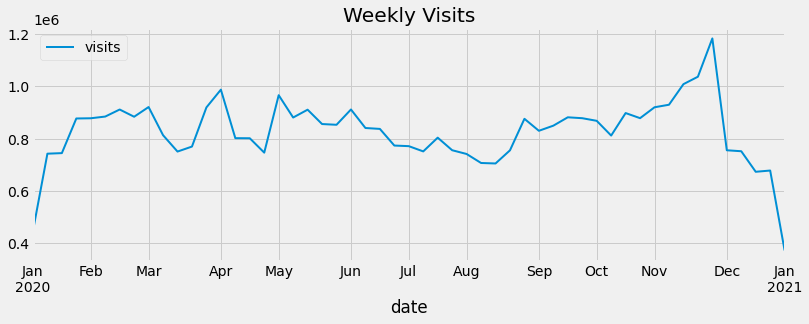

In [106]:
plot_ts_data(visits_on_pdp.set_index('date').drop('product_id', axis=1), 
             plot_daily=False, plot_weekly=True, title='Visits')

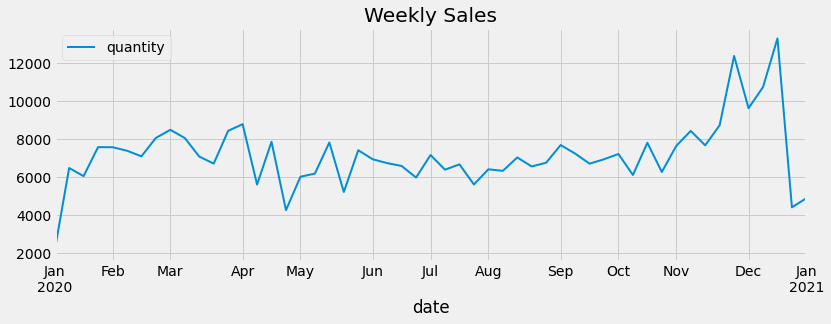

In [28]:
plot_ts_data(sales.set_index('date').drop('product_id', axis=1),
             plot_daily=False, plot_weekly=True, title='Sales')

- We see something interesting in December here. The page visit count has gone down, whereas the sales have gone up. 

#### Sales across categories

In [29]:
sales_products = sales.merge(product_details, on=['product_id'], how='left')

**Monthly Sales**

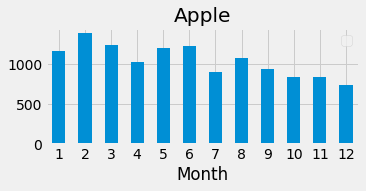

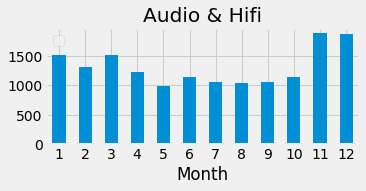

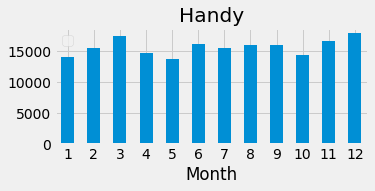

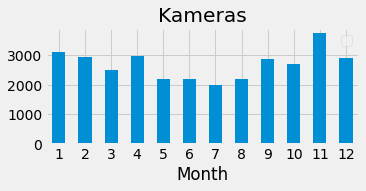

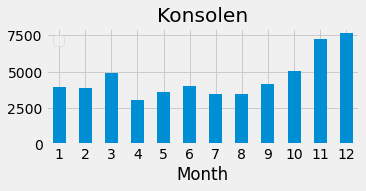

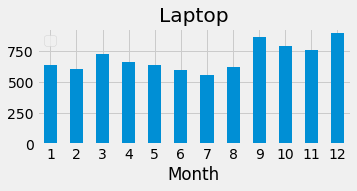

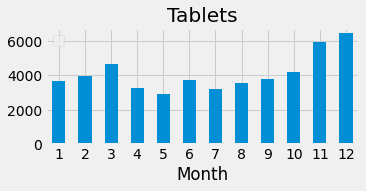

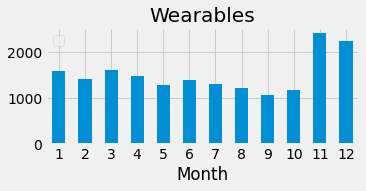

In [34]:
sales_products_agg = sales_products.set_index('date').groupby('main_category').resample('M')['quantity']\
    .sum().reset_index()

for category in sales_products_agg['main_category'].unique():
    x = sales_products_agg[sales_products_agg['main_category'] == category]
    x = x.drop('main_category', axis=1)
    x = x.set_index('date')
    x.plot(linewidth=config.lw, figsize=(5, 2), kind='bar')
    plt.xticks(ticks=range(len(x)), labels=x.index.month, rotation=0)
    plt.legend('')
    plt.xlabel('Month')
    plt.title(category);

- Phone sales seem to be steady throughout the year.
- Tablets, Consoles and Wearables go up in sales during November and December, probably because they are gifted often. 

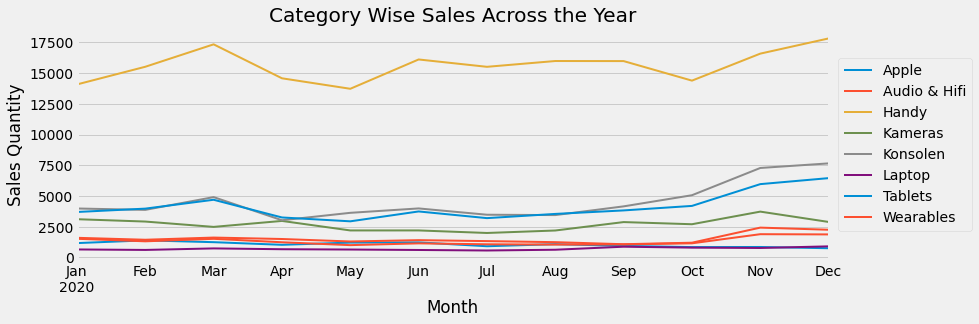

In [35]:
sales_products_agg.pivot(index='date', columns='main_category', values='quantity')\
    .plot(linewidth=config.lw, figsize=config.FIGSIZE)
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Category Wise Sales Across the Year')
plt.xlabel('Month')
plt.ylabel('Sales Quantity');

- Phones are by far the highest selling product on the platform. Consoles and Tablets sell well during November and December.

**Visits by Category**

In [36]:
visits_products = visits_on_pdp.merge(product_details, on='product_id', how='left')
visits_products_agg = visits_products.set_index('date').groupby('main_category').resample('M')['visits']\
    .sum().reset_index()

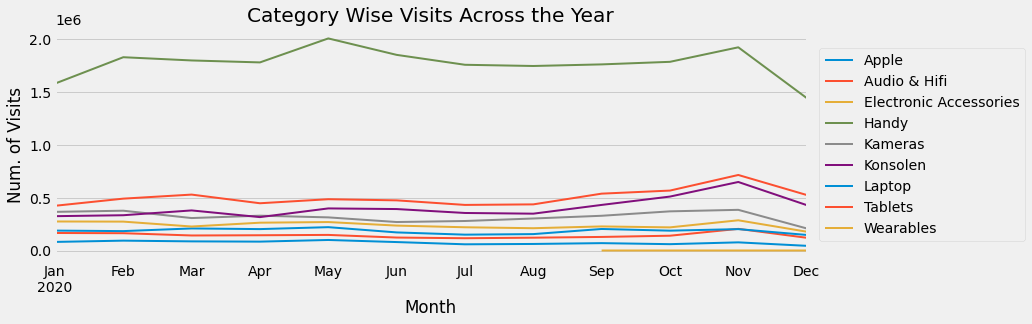

In [37]:
visits_products_agg.pivot(index='date', columns='main_category', values='visits')\
    .plot(linewidth=config.lw, figsize=config.FIGSIZE)
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('Category Wise Visits Across the Year')
plt.xlabel('Month')
plt.ylabel('Num. of Visits');

- The drop in visits in December is happening for all product categories, but the absolute drop is highest for Handy, probably because it's the largest category.

Let's calculate the conversion ratio as: sales/visits

In [38]:
visits_sales = visits_sales.set_index('date')

In [42]:
visits_sales = visits_sales.groupby('product_id')['visits', 'sales'].resample('D').sum().reset_index()

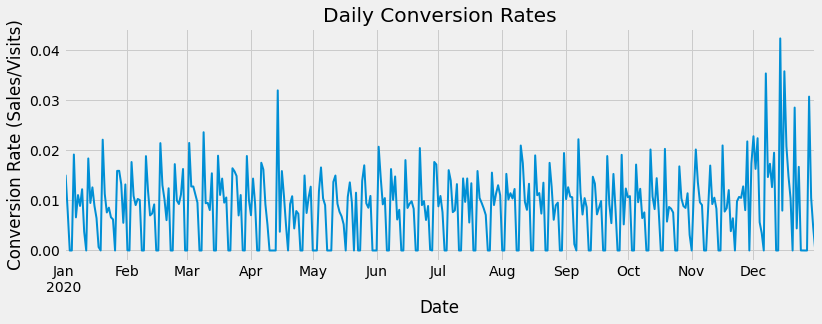

In [51]:
get_cvr(visits_sales.set_index('date'), 'D', 'Daily Conversion Rates')

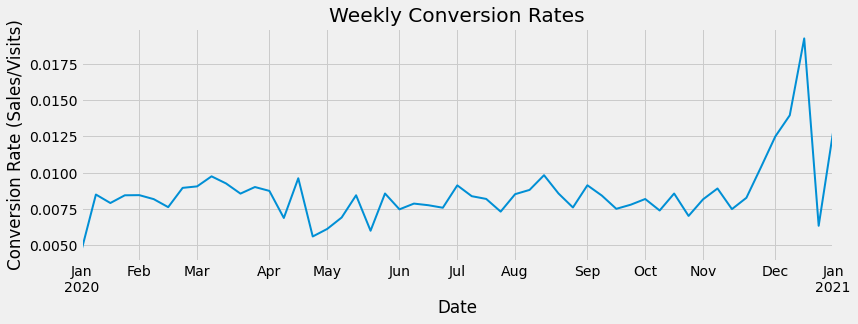

In [45]:
get_cvr(visits_sales.set_index('date'), 'W', 'Weekly Conversion Rates')

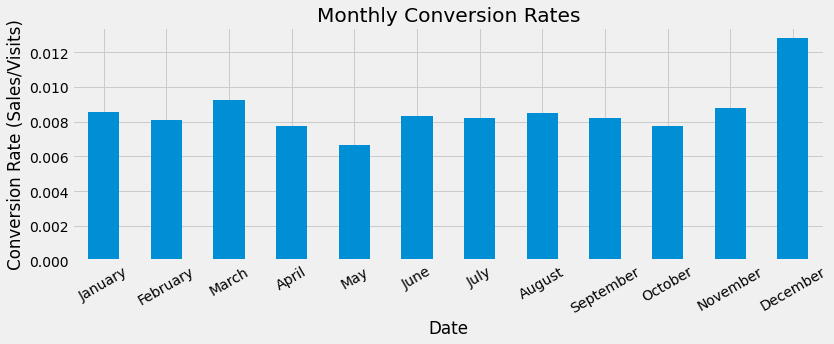

In [46]:
get_cvr(visits_sales.set_index('date'), 'M', 'Monthly Conversion Rates')

We see that on average, the conversion rate is around 2.5% but during December the conversion rate jumps up to 3.5% (A 40% increase in conversion)

Let's dig deeper and see how conversion rates are across different product categories.

In [48]:
visits_sales = visits_sales.merge(product_details.drop('manufacturer', axis=1), on='product_id', how='left')

In [52]:
visits_sales.head()

,product_id,date,visits,sales,main_category
0,61380,2020-01-01,1,0.0,Konsolen
1,61380,2020-01-02,5,0.0,Konsolen
2,61380,2020-01-03,2,0.0,Konsolen
3,61380,2020-01-04,7,0.0,Konsolen
4,61380,2020-01-05,5,0.0,Konsolen


In [72]:
category_wise_conv = (visits_sales.groupby('main_category')['sales'].sum()/visits_sales.groupby('main_category')['visits'].sum())\
    .sort_values(ascending=True).reset_index()

In [73]:
category_wise_conv.columns = ['Category', 'Conversion Rate']

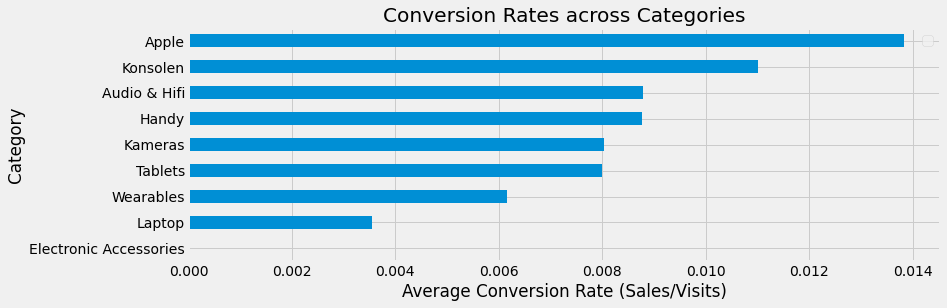

In [81]:
category_wise_conv.plot(kind='barh')
plt.yticks(ticks=range(9), labels=category_wise_conv['Category'].unique())
plt.xlabel('Average Conversion Rate (Sales/Visits)')
plt.ylabel('Category')
plt.title('Conversion Rates across Categories')
plt.legend('');

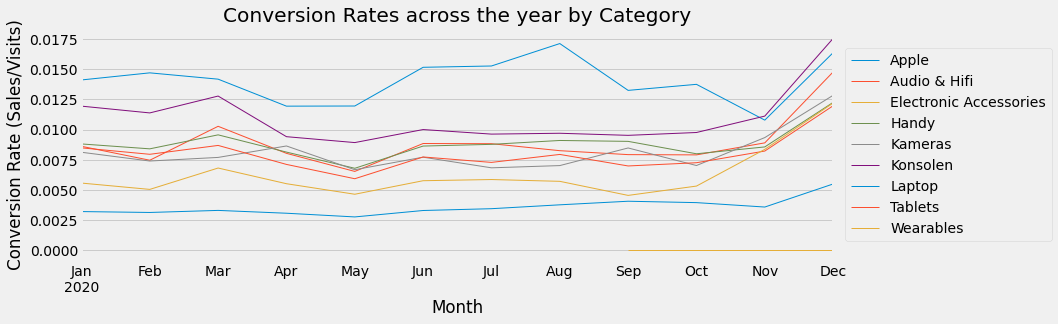

In [104]:
((visits_sales.set_index('date').groupby('main_category')['sales'].resample('M').sum())/\
(visits_sales.set_index('date').groupby('main_category')['visits'].resample('M').sum()))\
.reset_index().pivot(index='date', columns='main_category', values=0).plot(linewidth=1)

plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('Conversion Rates across the year by Category')
plt.ylabel('Conversion Rate (Sales/Visits)')
plt.xlabel('Month');

- Conversion rate for Apple products peak in August and dip in November.
- Conversion rates go up across all categories for the month of December.

### Availability Rates and Sales

In [28]:
availability = availability.fillna(0)

In [29]:
sales_availability = sales.merge(availability, on=['product_id', 'date'], how='left').fillna(0)

Let's try to understand the correlation of sales quantity with the availability rates of different variants.

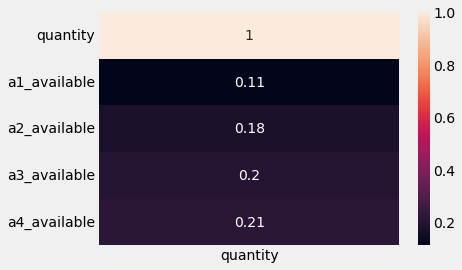

In [30]:
sns.heatmap(sales_availability.drop('product_id', axis=1).corr().loc[['quantity']].transpose(), annot=True);

We see that sales quantity is almost equally correlated with the availability rates of A2, A3 and A4 but not so much with A1. 